In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch

from CASBI.utils.create_dataframe import rescale
from CASBI.sbi.conf_yaml import generate_data_yaml, generate_training_yaml
from CASBI.sbi.gen_halo import  gen_halo_Nsubhalos, gen_halo
from CASBI.sbi.inference import run_inference, load_posterior, infer_observation, evaluate_posterior, calibrarion

In [2]:
! cd ../../../../data/vgiusepp/complete_inference/; tree

.
├── N_subhalos_data
│   ├── N_subhalos.npy
│   ├── N_subhalos_0.npy
│   ├── N_subhalos_test.npy
│   ├── x.npy
│   ├── x_0.npy
│   └── x_test.npy
├── N_subhalos_data.yaml
├── N_subhalos_training.yaml
├── data
├── data.yaml
└── training.yaml

2 directories, 10 files


In [4]:
#generate the yaml file for the two inference part 
inference_dir = "../../../../data/vgiusepp/complete_inference/" #where all the data and yaml file will be stored

#Number of subhalos inference
yaml_N_subhalos_data_path = os.path.join(inference_dir, "N_subhalos_data.yaml")
yamL_N_subhalos_training_path = os.path.join(inference_dir, "N_subhalos_training.yaml")
generate_data_yaml(filepath=yaml_N_subhalos_data_path, 
                   in_dir=os.path.join(inference_dir, 'N_subhalos_data/'), #where the data are stored
                   theta_file='N_subhalos.npy',
                   thetafid_file='N_subhalos_0.npy')
generate_training_yaml(filepath=yamL_N_subhalos_training_path,)


#Subhalos properties inference
yaml_data_path = os.path.join(inference_dir, "data.yaml")
yaml_training_path = os.path.join(inference_dir, "training.yaml")
generate_data_yaml(filepath=yaml_data_path, 
                   in_dir=os.path.join(inference_dir, 'data/')) #where the data are stored
generate_training_yaml(filepath=yaml_training_path,)

In [3]:
#loading and rescaling the data
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameters=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)

#generate halos for the training of the N_subhalos inference 
_ = gen_halo_Nsubhalos(data=data,
                       output_dir=os.path.join(inference_dir, ),
                       n_test=10,
                       n_train=100,)

finish prepare the data


In [8]:
#train the posterior
# run_inference(yamL_N_subhalos_training_path, yaml_N_subhalos_data_path)

#load the posterior from pkl file 
posterior = load_posterior('./ltu_ili_test/n_subhalo_finder/toy_NPE_posterior_best.pkl')

Drawing 2178 posterior samples:   0%|          | 0/2178 [00:00<?, ?it/s]

Drawing 2117 posterior samples:   0%|          | 0/2117 [00:00<?, ?it/s]

Drawing 3272 posterior samples:   0%|          | 0/3272 [00:00<?, ?it/s]

Drawing 2433 posterior samples:   0%|          | 0/2433 [00:00<?, ?it/s]

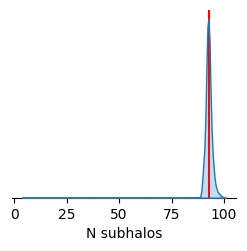

In [13]:
#evaluate posterior
fig = evaluate_posterior(posterior, observation_path=os.path.join(inference_dir, 'N_subhalos_data/x_0.npy'), parameter_path=os.path.join(inference_dir, 'N_subhalos_data/N_subhalos_0.npy'), labels=['N subhalos'], n_samples=10000)

In [31]:
samples = infer_observation(posterior, observation_path=os.path.join(inference_dir, 'N_subhalos_data/x_0.npy'), n_samples=10_000)
print(r'$$<N_subhalos> \pm \sigma_{N_{subhalos}} $$:', samples.mean().cpu(), '+-', samples.std().cpu())
print('original value:', np.load(os.path.join(inference_dir, 'N_subhalos_data/N_subhalos_0.npy')))

Drawing 2251 posterior samples:   0%|          | 0/2251 [00:00<?, ?it/s]

Drawing 1998 posterior samples:   0%|          | 0/1998 [00:00<?, ?it/s]

Drawing 3298 posterior samples:   0%|          | 0/3298 [00:00<?, ?it/s]

Drawing 2453 posterior samples:   0%|          | 0/2453 [00:00<?, ?it/s]

$$<N_subhalos> \pm \sigma_{N_{subhalos}} $$: tensor(92.6676) +- tensor(1.7903)
original value: [93]


  0%|          | 0/979 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


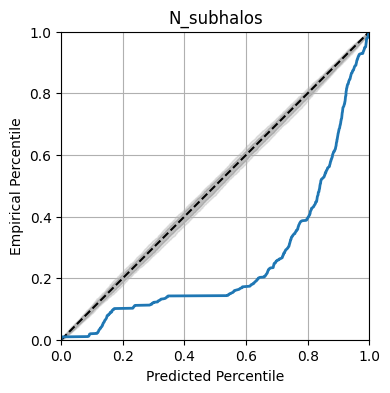

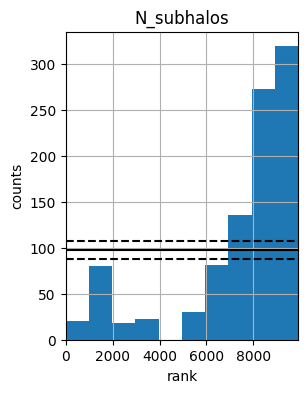

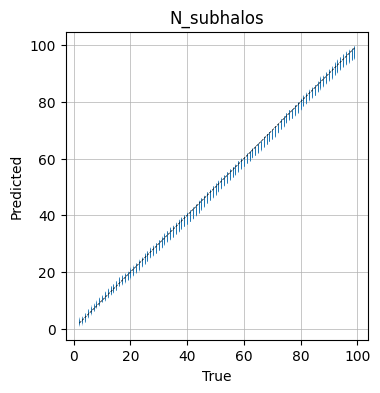

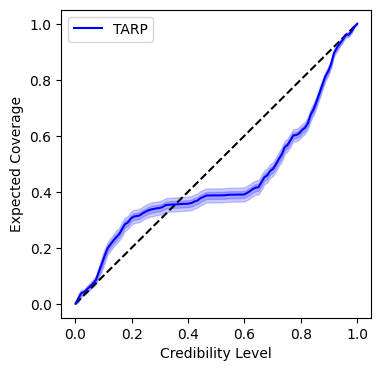

In [35]:
fig = calibrarion(posterior=posterior, observation_test_path=os.path.join(inference_dir, 'N_subhalos_data/x_test.npy'), parameter_test_path=os.path.join(inference_dir, 'N_subhalos_data/N_subhalos_test.npy'), n_samples=10_000, labels=['N_subhalos'])